# 02. CNN Feature Extraction

Ekstraksi fitur dari gambar menggunakan CNN (ResNet50 dan MobileNetV3) untuk klasifikasi SVM.

**Input:** Dataset gambar dari preprocessing  
**Output:** Fitur CNN untuk training SVM

## Import Libraries

In [34]:
import os
import pandas as pd
import numpy as np
import json
import zipfile
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Load Data

In [35]:
with open('/kaggle/input/01-preprocessing-result/01-Preprocessing/dataset_info.json', 'r') as f:
    dataset_info = json.load(f)

train_df = pd.read_csv('/kaggle/input/01-preprocessing-result/01-Preprocessing/train_dataset.csv')
val_df = pd.read_csv('/kaggle/input/01-preprocessing-result/01-Preprocessing/val_dataset.csv')
test_df = pd.read_csv('/kaggle/input/01-preprocessing-result/01-Preprocessing/test_dataset.csv')

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")
print(f"Classes: {dataset_info['classes']}")

Train: 12600 samples
Val: 2700 samples
Test: 2700 samples
Classes: ['Organik', 'Anorganik', 'Lainnya']


## Dataset Class

In [36]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, dataset_base_path, transform=None, strict=True):
        self.df = dataframe.reset_index(drop=True)
        self.dataset_base_path = dataset_base_path
        self.transform = transform
        self.strict = strict 
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        original_path = row['image_path']
        label = row['class_idx']
        
        path_parts = original_path.replace('\\', '/').split('/')
        class_name = path_parts[-2]
        filename = path_parts[-1]
        
        local_path = os.path.join(self.dataset_base_path, class_name, filename)
        
        if not os.path.exists(local_path):
            msg = f"File not found: {local_path} (derived from {original_path})"
            if self.strict:
                raise FileNotFoundError(msg)
            else:
                print(msg)
                return None
        
        try:
            image = Image.open(local_path).convert('RGB')
        except Exception as e:
            msg = f"Error opening image {local_path}: {e}"
            if self.strict:
                raise RuntimeError(msg)
            else:
                print(msg)
                return None
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, local_path

## CNN Feature Extractor

In [37]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self, model_name='resnet50'):
        super().__init__()
        
        if model_name == 'resnet50':
            model = models.resnet50(pretrained=True)
            self.features = nn.Sequential(*list(model.children())[:-1])
            self.feature_dim = 2048
        elif model_name == 'mobilenetv3':
            model = models.mobilenet_v3_large(pretrained=True)
            self.features = model.features
            self.avgpool = model.avgpool
            self.feature_dim = 960
        
        for param in self.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        if hasattr(self, 'avgpool'):
            x = self.features(x)
            x = self.avgpool(x)
        else:
            x = self.features(x)
        return x.flatten(1)

resnet_extractor = CNNFeatureExtractor('resnet50').to(device)
mobilenet_extractor = CNNFeatureExtractor('mobilenetv3').to(device)

print(f"ResNet50 feature dim: {resnet_extractor.feature_dim}")
print(f"MobileNetV3 feature dim: {mobilenet_extractor.feature_dim}")

ResNet50 feature dim: 2048
MobileNetV3 feature dim: 960


## Data Transform

In [38]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset_base_path = input("Please enter the path to your dataset-sampah folder (e.g., D:\\path\\to\\dataset-sampah): ").strip()
if not os.path.exists(dataset_base_path):
    print(f"Warning: Dataset path {dataset_base_path} does not exist!")
    print("Please make sure you have the dataset-sampah folder with Organik, Anorganik, and Lainnya subfolders.")
else:
    print(f"Using dataset path: {dataset_base_path}")

Please enter the path to your dataset-sampah folder (e.g., D:\path\to\dataset-sampah):  /kaggle/input/dataset-sampah


Using dataset path: /kaggle/input/dataset-sampah


## Extract Features

In [39]:
def extract_features(model, dataloader, model_name):
    model.eval()
    features = []
    labels = []
    paths = []
    
    with torch.no_grad():
        for images, label_batch, path_batch in tqdm(dataloader, desc=f'Extracting {model_name}'):
            images = images.to(device)
            feat = model(images)
            
            features.append(feat.cpu().numpy())
            labels.extend(label_batch.numpy())
            paths.extend(path_batch)
    
    return np.vstack(features), np.array(labels), paths

splits = {'train': train_df, 'val': val_df, 'test': test_df}
results = {}

for split_name, df in splits.items():
    print(f"\nProcessing {split_name} split...")
            
    dataset = ImageDataset(df, dataset_base_path, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
    
    # Extract ResNet50 features
    resnet_features, labels, paths = extract_features(resnet_extractor, dataloader, 'ResNet50')
    
    # Extract MobileNetV3 features
    mobilenet_features, _, _ = extract_features(mobilenet_extractor, dataloader, 'MobileNetV3')
    
    results[split_name] = {
        'resnet_features': resnet_features,
        'mobilenet_features': mobilenet_features,
        'labels': labels,
        'paths': paths
    }
    
    print(f"ResNet50 features: {resnet_features.shape}")
    print(f"MobileNetV3 features: {mobilenet_features.shape}")


Processing train split...


Extracting MobileNetV3: 100%|██████████| 394/394 [00:59<00:00,  6.58it/s]


ResNet50 features: (12600, 2048)
MobileNetV3 features: (12600, 960)

Processing val split...


Extracting MobileNetV3: 100%|██████████| 85/85 [00:11<00:00,  7.46it/s]


ResNet50 features: (2700, 2048)
MobileNetV3 features: (2700, 960)

Processing test split...


Extracting MobileNetV3: 100%|██████████| 85/85 [00:12<00:00,  6.91it/s]

ResNet50 features: (2700, 2048)
MobileNetV3 features: (2700, 960)


### Visualisasi Internal CNN
Menampilkan filter awal (first conv) dan peta aktivasi (feature maps) dari layer awal & menengah untuk dokumentasi ilmiah.

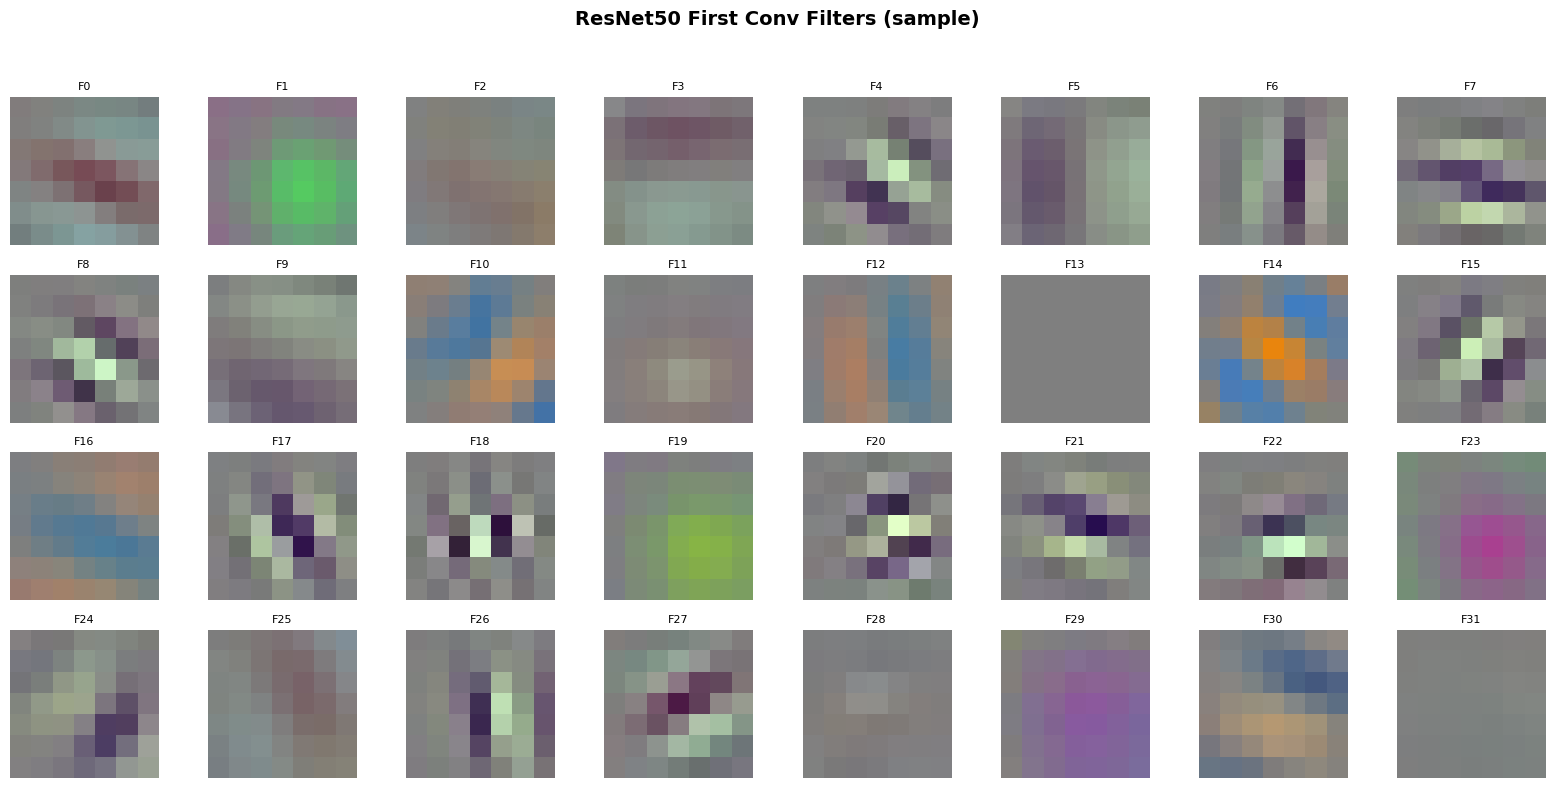

Saved: ./CNN_features/visualizations/resnet_first_conv_filters.png


In [40]:
import matplotlib.pyplot as plt
import math
os.makedirs('./CNN_features/visualizations', exist_ok=True)

first_conv = models.resnet50(pretrained=True).conv1
weights = first_conv.weight.data.clone()
w_min, w_max = weights.min(), weights.max()
weights = (weights - w_min) / (w_max - w_min)

n_filters = min(32, weights.shape[0])
cols = 8
rows = math.ceil(n_filters/cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    ax.axis('off')
    if i < n_filters:
        f = weights[i].permute(1,2,0).numpy()
        ax.imshow(f)
        ax.set_title(f'F{i}', fontsize=8)
plt.suptitle('ResNet50 First Conv Filters (sample)', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.savefig('./CNN_features/visualizations/resnet_first_conv_filters.png', dpi=160)
plt.show()
print('Saved: ./CNN_features/visualizations/resnet_first_conv_filters.png')

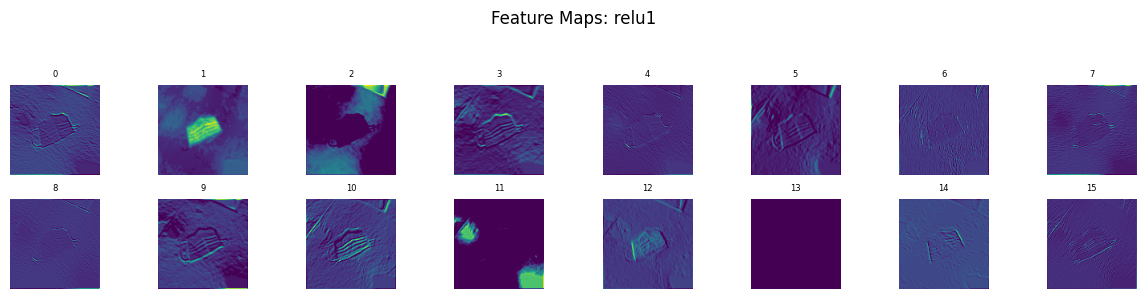

Saved: ./CNN_features/visualizations/resnet_relu1_featuremaps.png


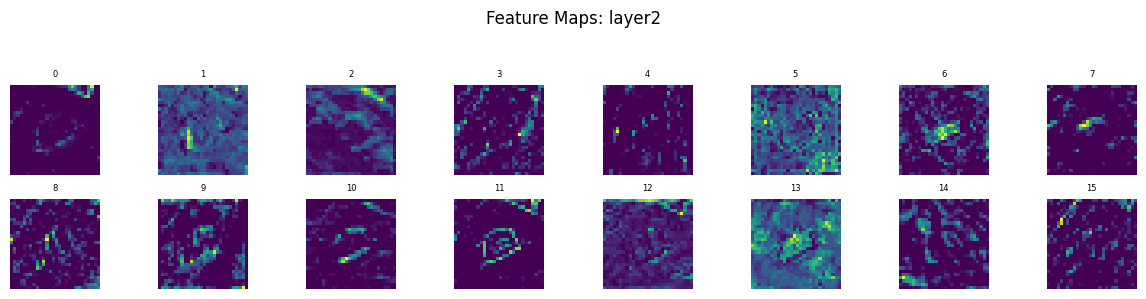

Saved: ./CNN_features/visualizations/resnet_layer2_featuremaps.png


In [41]:
from torchvision import transforms as T
resnet_model_full = models.resnet50(pretrained=True).to(device).eval()

feature_maps = {}

def get_hook(name):
    def hook(module, input, output):
        feature_maps[name] = output.detach().cpu()
    return hook

resnet_model_full.relu.register_forward_hook(get_hook('relu1'))
resnet_model_full.layer2.register_forward_hook(get_hook('layer2'))

sample_path = train_df.sample(1, random_state=2024)['image_path'].iloc[0]
parts = sample_path.split('/')
cls_name = parts[-2]; fname = parts[-1]
local_path = os.path.join(dataset_base_path, cls_name, fname)
img = Image.open(local_path).convert('RGB')
prep = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
input_tensor = prep(img).unsqueeze(0).to(device)
_ = resnet_model_full(input_tensor)

for layer_name in ['relu1','layer2']:
    fmap = feature_maps[layer_name][0]
    n_maps = min(16, fmap.shape[0])
    cols = 8
    rows = (n_maps + cols - 1)//cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*1.5, rows*1.5))
    for i in range(rows*cols):
        ax = axes.flatten()[i]
        ax.axis('off')
        if i < n_maps:
            fm = fmap[i].numpy()
            fm -= fm.min(); fm /= (fm.max()+1e-6)
            ax.imshow(fm, cmap='viridis')
            ax.set_title(f'{i}', fontsize=6)
    plt.suptitle(f'Feature Maps: {layer_name}', fontsize=12)
    plt.tight_layout(rect=[0,0,1,0.93])
    out_path = f'./CNN_features/visualizations/resnet_{layer_name}_featuremaps.png'
    plt.savefig(out_path, dpi=160)
    plt.show()
    print('Saved:', out_path)

## Save Features

In [42]:
OUTPUT_DIR = './CNN_features'
os.makedirs(OUTPUT_DIR, exist_ok=True)

for split_name, data in results.items():
    np.save(f'{OUTPUT_DIR}/{split_name}_resnet_features.npy', data['resnet_features'])
    np.save(f'{OUTPUT_DIR}/{split_name}_mobilenet_features.npy', data['mobilenet_features'])
    np.save(f'{OUTPUT_DIR}/{split_name}_labels.npy', data['labels'])
    
    pd.DataFrame({'paths': data['paths']}).to_csv(f'{OUTPUT_DIR}/{split_name}_paths.csv', index=False)

metadata = {
    'resnet_feature_dim': resnet_extractor.feature_dim,
    'mobilenet_feature_dim': mobilenet_extractor.feature_dim,
    'classes': dataset_info['classes'],
    'splits': {k: len(v['labels']) for k, v in results.items()}
}

with open(f'{OUTPUT_DIR}/feature_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\nFeatures saved to {OUTPUT_DIR}")
print(f"ResNet50: {resnet_extractor.feature_dim} dimensions")
print(f"MobileNetV3: {mobilenet_extractor.feature_dim} dimensions")


Features saved to ./CNN_features
ResNet50: 2048 dimensions
MobileNetV3: 960 dimensions


## Feature Extraction Summary Report

In [43]:
summary_report = f"""
JakOlah Classifier - Feature Extraction Summary Report

CNN Feature Extraction Overview
- CNN Models: ResNet50, MobileNetV3
- Feature Dimensions: ResNet50 ({metadata['resnet_feature_dim']}), MobileNetV3 ({metadata['mobilenet_feature_dim']})
- Classes: {len(metadata['classes'])} ({', '.join(metadata['classes'])})
- Processing Device: {device}

Dataset Splits
- Training: {metadata['splits']['train']:,} samples
- Validation: {metadata['splits']['val']:,} samples
- Testing: {metadata['splits']['test']:,} samples

Feature Extraction Pipeline
1. Image Loading: PIL with RGB conversion
2. Preprocessing: Resize to 224x224, ImageNet normalization
3. CNN Processing: Pre-trained models
4. Feature Extraction: Before final classification layers
5. Batch Processing: 32 samples per batch, GPU utilization

Model Architectures
- ResNet50: Deep residual network, {metadata['resnet_feature_dim']} feature dimensions
- MobileNetV3: Lightweight CNN, {metadata['mobilenet_feature_dim']} feature dimensions
- Transfer Learning: ImageNet pre-trained weights
- Feature Source: Global average pooling output

Output Files
- Feature files (.npy): CNN features for train/val/test splits
- Label files (.npy): Corresponding class labels
- Path files (.csv): Image file paths for reference
- feature_metadata.json: Model specifications and metadata

Processing Statistics
- Total Images: {sum(metadata['splits'].values()):,}
- Features per Image: ResNet50 ({metadata['resnet_feature_dim']}), MobileNetV3 ({metadata['mobilenet_feature_dim']})
- Storage Format: NumPy arrays (float32)
- Processing Mode: Batch inference (no gradient computation)
"""

print(summary_report)

with open(f'{OUTPUT_DIR}/feature_extraction_report.md', 'w', encoding='utf-8') as f:
    f.write(summary_report)

print(f"Feature extraction completed successfully!")
print(f"All files saved to: {OUTPUT_DIR}")
print(f"Summary report saved to: {OUTPUT_DIR}/feature_extraction_report.md")


JakOlah Classifier - Feature Extraction Summary Report

CNN Feature Extraction Overview
- CNN Models: ResNet50, MobileNetV3
- Feature Dimensions: ResNet50 (2048), MobileNetV3 (960)
- Classes: 3 (Organik, Anorganik, Lainnya)
- Processing Device: cuda

Dataset Splits
- Training: 12,600 samples
- Validation: 2,700 samples
- Testing: 2,700 samples

Feature Extraction Pipeline
1. Image Loading: PIL with RGB conversion
2. Preprocessing: Resize to 224x224, ImageNet normalization
3. CNN Processing: Pre-trained models
4. Feature Extraction: Before final classification layers
5. Batch Processing: 32 samples per batch, GPU utilization

Model Architectures
- ResNet50: Deep residual network, 2048 feature dimensions
- MobileNetV3: Lightweight CNN, 960 feature dimensions
- Transfer Learning: ImageNet pre-trained weights
- Feature Source: Global average pooling output

Output Files
- Feature files (.npy): CNN features for train/val/test splits
- Label files (.npy): Corresponding class labels
- Path f

## Create Results ZIP Package

In [44]:
def create_feature_extraction_zip():
    zip_filename = f'02-Feature-Extraction-Results.zip'
    
    print(f"Creating feature extraction results ZIP: {zip_filename}")
    
    files_to_zip = [
        f'{OUTPUT_DIR}/train_resnet_features.npy',
        f'{OUTPUT_DIR}/train_mobilenet_features.npy',
        f'{OUTPUT_DIR}/train_labels.npy',
        f'{OUTPUT_DIR}/train_paths.csv',
        f'{OUTPUT_DIR}/val_resnet_features.npy',
        f'{OUTPUT_DIR}/val_mobilenet_features.npy',
        f'{OUTPUT_DIR}/val_labels.npy',
        f'{OUTPUT_DIR}/val_paths.csv',
        f'{OUTPUT_DIR}/test_resnet_features.npy',
        f'{OUTPUT_DIR}/test_mobilenet_features.npy',
        f'{OUTPUT_DIR}/test_labels.npy',
        f'{OUTPUT_DIR}/test_paths.csv',
        f'{OUTPUT_DIR}/feature_metadata.json',
        f'{OUTPUT_DIR}/feature_extraction_report.md'
    ]
    
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        files_added = 0
        
        for file_path in files_to_zip:
            if os.path.exists(file_path):
                arcname = f"02-Feature-Extraction/{os.path.basename(file_path)}"
                zipf.write(file_path, arcname)
                print(f"Added: {os.path.basename(file_path)}")
                files_added += 1
            else:
                print(f"Missing: {os.path.basename(file_path)}")
        
        readme_content = f"""# JakOlah Classifier - Feature Extraction Results

## CNN Feature Extraction Information
- CNN Models: ResNet50, MobileNetV3
- Feature Dimensions: ResNet50 ({metadata['resnet_feature_dim']}), MobileNetV3 ({metadata['mobilenet_feature_dim']})
- Classes: {', '.join(metadata['classes'])}
- Processing Device: {device}

## Files Included
- Feature files (.npy): CNN features for train/val/test splits
- Label files (.npy): Corresponding class labels for each split
- Path files (.csv): Image file paths for reference
- feature_metadata.json: Model specifications and metadata
- feature_extraction_report.md: Comprehensive extraction report

## Extraction Configuration
- Models: Pre-trained ResNet50 & MobileNetV3 (ImageNet)
- Input Size: 224x224 pixels
- Normalization: ImageNet standard (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
- Batch Processing: 32 samples per batch
- Feature Source: Before final classification layers
- Processing: GPU-accelerated feature extraction

## Dataset Splits
- Train: {metadata['splits']['train']:,} samples
- Validation: {metadata['splits']['val']:,} samples
- Test: {metadata['splits']['test']:,} samples
- Total: {sum(metadata['splits'].values()):,} samples
"""
        
        zipf.writestr('02-Feature-Extraction/README.md', readme_content)
        files_added += 1
    
    zip_size = os.path.getsize(zip_filename) / (1024 * 1024)
    print(f"\nFeature Extraction ZIP created:")
    print(f"- File: {zip_filename}")
    print(f"- Size: {zip_size:.2f} MB")
    print(f"- Files: {files_added}")
    
    return zip_filename

feature_extraction_zip = create_feature_extraction_zip()

print(f"\nFeature Extraction Stage Complete!")
print(f"- ResNet50 features: {resnet_extractor.feature_dim} dimensions")
print(f"- MobileNetV3 features: {mobilenet_extractor.feature_dim} dimensions")
print(f"- Total samples processed: {sum(metadata['splits'].values()):,}")
print(f"- Results packaged: {feature_extraction_zip}")

Creating feature extraction results ZIP: 02-Feature-Extraction-Results.zip
Added: train_resnet_features.npy
Added: train_mobilenet_features.npy
Added: train_labels.npy
Added: train_paths.csv
Added: val_resnet_features.npy
Added: val_mobilenet_features.npy
Added: val_labels.npy
Added: val_paths.csv
Added: test_resnet_features.npy
Added: test_mobilenet_features.npy
Added: test_labels.npy
Added: test_paths.csv
Added: feature_metadata.json
Added: feature_extraction_report.md

Feature Extraction ZIP created:
- File: 02-Feature-Extraction-Results.zip
- Size: 188.23 MB
- Files: 15

Feature Extraction Stage Complete!
- ResNet50 features: 2048 dimensions
- MobileNetV3 features: 960 dimensions
- Total samples processed: 18,000
- Results packaged: 02-Feature-Extraction-Results.zip
